# <font color='purple'>04-Polytrops</font> (Template)

We start by importing the modules
* Numpy -- operations on arrays and matrixes (and pi)
* Matplotlib pyplot -- plotting library
* Astropy units -- defined quantities with units. We also import the CDS conversions

In [1]:
import numpy as np, copy
import matplotlib.pyplot as plt
%matplotlib inline
from astropy import constants as const
import astropy.units as u
from astropy.units import cds
cds.enable() 

## 1. Below are a few functions that we will need -- please execute them

### a. MESA evolution code

MESA is an open-source code that performs detailed calculations for the structure and evolution of stars. Throughout the course, we will be using models calcualted with MESA -- if you are interested, you can find more details here: http://mesastar.org/. 

And here's a little function that will allow you to read a Solar model calculated from the MESA code.

In [2]:
def read_model(file):

    cols = np.array([1,2,3,4,5,29,66])-1
    return np.genfromtxt(file, skip_header=5, names=True, usecols = cols)

### b. Numerical solution of the Lane-Emden equation

Here I provide a function to numerically calculate the $\theta(\epsilon)$ function for a polytropic index $n>1$, such that
$$\rho(r) = \rho_c \theta(r)^n.$$

If you are interested in the numerical procedure, see Hansen & Kawaler sec 7.2.2.

In [3]:
def Lane_zp(x, y, z, n):
    if y < 0:
        y = 0
    return -2.0 * z / x - y**n

def poly_num(n, h=0.01, x_end=16.0, xinit=0.00001):
    # Initialize the step and the ending eps value
    # n: polytrope index
    # h: 0.05 step size
    # x_end: 16.0 

    # Initialize the starting value
    x = xinit
    y = 1 - ( 1.0/6.0 * x**2)  + ( n/120.0 * x**4 ) - ( n*(8*n-5)/15120.0 * x**6 )
    z = - ( 1.0/6.0 * 2 * x ) + ( n/120.0 * 4 * x**3 )  - ( n*(8*n-5)/15120.0 * 6 * x**5 )
    zp = - ( 1.0/6.0 * 2 ) + ( n/120.0 * 12 * x**2 )  - ( n*(8*n-5)/15120.0 * 6*5 * x**4 )

    eps = np.array([h])
    theta = np.array([y])
    theta_prim = np.array([z])

    # Make the calculation until we reach X_end, of theta goes to zero
    while (x < x_end) and (y>0):
    
        K1 = h * z
        L1 = h * Lane_zp(x, y, z, n)
        K2 = h * (z + L1/2.0)
        L2 = h * Lane_zp(x+h/2.0, y+K1/2.0, z+L1/2.0, n)
        K3 = h * (z + L2/2.0)
        L3 = h * Lane_zp(x+h/2.0, y+K2/2.0, z+L2/2.0, n)
        K4 = h * (z + L3/2.0)
        L4 = h * Lane_zp(x+h, y+K3, z+L3, n)
    
        y = y + K1/6.0 + K2/3.0 + K3/3.0 + K4/6.0
        z = z + L1/6.0 + L2/3.0 + L3/3.0 + L4/6.0
    
        x = x+h
    
        eps = np.append(eps, x)
        theta = np.append(theta, y)
        theta_prim = np.append(theta_prim, z)
        
    return eps[0:eps.size-1], theta[0:theta.size-1], theta_prim[0:theta_prim.size-1]

## 2. Analytical solutions for polytrops

### a. Let's define some function that return $\theta(r)$ for the analytical solutions of the Lane-Emden equation

For n = 0,
$$\theta(\epsilon) = 1 - \frac{\epsilon^2}{6}.$$

For n = 1, 

$$\theta(\epsilon) = \frac{\sin \epsilon}{\epsilon}$$

For n = 5,
$$\theta(\epsilon) = \frac{1.0}{(1.0+\epsilon^{2}/3)^{1/2}}$$

In [4]:
#-------------------------------------------------------
# In class: we will learn how to define functions
def poly_n0(eps):
  #eps is an array of epsilon values
  return (1-eps**2/6)

def poly_n1(eps):
  return(np.sin(eps)/eps)

def poly_n5(eps):
  return(1.0/(1.0+eps**(2)/3)**0.5)


### b. Let's now look at what these solutions look like

We will first plot the analytic solutions, and then compare to the numerical solutions.

> **TODO** from now on: <font color='red'>please properly label the figure axes for your all of your notebooks</font>

Text(27.125, 0.5, '$\\theta(r)$')

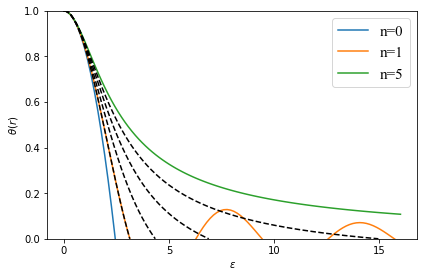

In [5]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.family': 'Times New Roman'})

ax.set_ylim(0,1)
#---------------------------------------
#---------------------------------------
# In class

######################
# Analytical solutions

# Define a setof eps values
eps=np.linspace(0.01,16,100)
######################
ax.plot(eps,poly_n0(eps),label='n=0')
ax.plot(eps,poly_n1(eps),label='n=1')
ax.plot(eps,poly_n5(eps),label='n=5')



######################
# numerical solutions
######################

# the function poly_num(n) will return
# an array of eps values, an array of theta values, 
# and an array of dTheta/dEps.
# The last element of the array is eps_1 (if n<5)


n=[1,2,3,4]

for item in n:
  eps, theta, theta_p = poly_num(item)
  ax.plot(eps,theta,c='k',ls='--')
    

#---------------------------------------
#---------------------------------------
ax.legend(loc=0, fontsize=15)
plt.tight_layout()
#-----------------------------------------
# Not included, they can do this themselves from now on. 
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel(r'$\theta(r)$')

> **TODO**: <font color='red'>Please write a small paragraph with an interpretation of the result obtained:</font>

**ANSWER**: This plot shows us how $\theta(\epsilon)$ varies for a given value of $n$. For each case, the surface of the corresponding star is denoted by $\epsilon_1$, which is located where each curve crosses the $x$ axis. 

## 3. Comparison with the density profile of the Sun

### a.  In class: what does the density profile look like for various polytrops compared to the Sun?

I provide you with a plot of $\rho / \rho_c$ for a detailed model of the Sun, calculated by MESA.

The numerical calculation returns $\epsilon$ and $\theta(\epsilon)$. We need to transform these into $r/R_\star$ and $\rho/\rho_c$.

> **TODO** <font color='red'>: Summarize the procedure here in words and math. Use Latex formatting to render the math</font>

**ANSWER**: To find these density profile comparisons, we first should define $\epsilon=\frac{r}{\alpha}$. A polytropic model also tells lets us define density as a function of radius by: $\rho(r)=\rho_0\theta^n(r)$. A location where we know certain values is at the star's surface. So at the surface, $(r=R_\star)$, $\epsilon=\epsilon_0$, and $\theta(\epsilon=\epsilon_0)=0$. From the relationship between $r$ and $\epsilon$, $$R_\star=\alpha \epsilon_1$$ where $$\frac{\epsilon}{\epsilon_1}=\frac{r}{R_\star}$$ and $$\alpha=\frac{P_0(n+1)}{4\pi G \rho_0^2}$$. By definition, we can now relate $\theta^n(t)$ to $\rho(r)$ by simply dividing by $\rho_0$. $$\frac{\rho(r)}{\rho_0}=\theta^n(r)$$.

> **TODO**: <font color="red">Using the code below, find out which polytropic index $n$ is a best match for the Sun. (Note that the polytropic index can be a fractional number)</font>

Text(20.375, 0.5, '$\\rho / \\rho_c$')

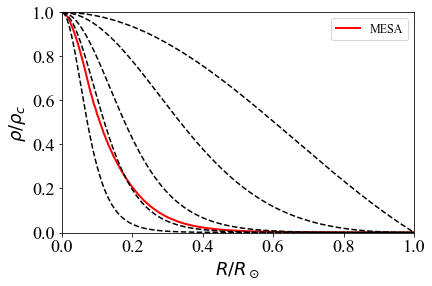

In [6]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.family': 'Times New Roman'})

ax.set_xlim(0,1)
ax.set_ylim(0,1)

# MESA solar model
mesa = read_model('https://raw.githubusercontent.com/veropetit/PHYS633-S2022/main/L04-Polytrops/04-MESAdatafile.txt')
# In the mesa model, the first element [0] correspond to the surface, 
# and the last element [mesa.size-1] correspond to the center.
mesa_r = 10**(mesa['logR']-mesa['logR'][0])
mesa_rho =  10**(mesa['logRho']-mesa['logRho'][mesa.size-1]) # the density is given in cgs
ax.plot(mesa_r, mesa_rho, c="red", lw=2, label='MESA')

#---------------------------------------
#---------------------------------------
# In class

# numerical solutions

n=[1,2,3,3.5,4]
for item in n:
  eps, theta, theta_p = poly_num(item)
  eps1=eps[-1]
  ax.plot(eps/eps1,theta**item,ls='--',c='k')
  #ax.legend(loc=0,fontsize=12)
    
    
#---------------------------------------   
#---------------------------------------
ax.legend(loc=0, fontsize=12)
plt.tight_layout()
#-----------------------------
# Not given
ax.set_xlabel(r'$R / R_\odot$')
ax.set_ylabel(r'$\rho / \rho_c$')

> **TODO**: <font color='red'>Please write a small paragraph with an interpretation of the result obtained:</font>

**ANSWER**: This plot shows density profiles for various polytropic models compared to that of the Sun. The Sun's density profile, obtained from MESA data, shows how density scales with radius. The black, dashed curves represent analytical solutions to the Lane-Emden equation. This returns values for $\theta$, $\frac{d\theta}{d\epsilon}$, and $\epsilon$ values. Using an $n$ index of $n=3.5$ seems to align close with the MESA model.


### b. At home: what is the central density for these polytrops?

In the plot below, I show the density, in g/cm$^3$, of the the detailed MESA solar model. 
 
> **TODO** In order to transform $\rho/\rho_c$ from above into a numerical density, you need to find the central density in g/cm$^3$. 
>
> **Hint**: before coding like a maniac, find an expression for the central density that is a function of only Msun and Rsun -- it becomes a much elegant expression with a cool meaning, if you remember that an average density of total volume / total mass...
>
> Include your derivation here (you can start from the set of 3 equations that are on the last slide from class).

<img src= "https://drive.google.com/uc?export=view&id=10v5VM19ECb47mKFt_JGSj9Nfs_u6dMtZ" width="500">

<img src= "https://drive.google.com/uc?export=view&id=1cikaNGrEZBYIyzmc7hNsul8YPGumDosE" width="500">
 
 

> **TODO**: in the code below, add curves for a few values of $n$, like we did in part 3a. Then find visualy the $n$ index that matches the central density of the sun the best. Use the astropy unit and constant packages, like we did on Tuesday.

Note that the numerical solution, the function poly_num(n) will return: 
1. an array of $\epsilon$ values, 
2. an array of $\theta(\epsilon)$ values, 
3. an array of $\frac{d\theta(\epsilon)}{d\epsilon}$ (or $\theta'(\epsilon)$)

The last element of the arrays correspond to $\epsilon_1$ (if $n<5$). Therefore the element `theta_p[-1]` corresponds to $\theta'(\epsilon_1)$

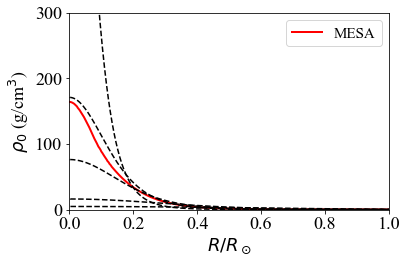

In [7]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.family': 'Times New Roman'})

ax.set_xlim(0,1)
ax.set_ylim(0,300)

# MESA solar model
mesa = read_model('https://raw.githubusercontent.com/veropetit/PHYS633-S2022/main/L04-Polytrops/04-MESAdatafile.txt')
# In the mesa model, the first element [0] correspond to the surface, 
# and the last element [mesa.size-1] correspond to the center.
mesa_r = 10**(mesa['logR']-mesa['logR'][0])
mesa_rho =  10**(mesa['logRho']) # the density is in cgs units.
ax.plot(mesa_r, mesa_rho, c="red", lw=2, label='MESA')

ax.set_xlabel(r'$R / R_\odot$')
ax.set_ylabel(r'$\rho_0$ (g/cm$^3$)')

#---------------------------------------
#---------------------------------------
# at home
n1=[1,2,3,3.4,4]
for item1 in n1:
  eps, theta, theta_p = poly_num(item1)
  eps1=eps[-1]
  rho0=(-u.M_sun*eps1)/(4*np.pi*u.R_sun**3*theta_p[-1])
  ax.plot(eps/eps1,theta**(item1)*rho0.to(u.g/u.cm**3),ls='--',c='k')

       







#-----------------------------
ax.legend(loc=0, fontsize=15)
plt.tight_layout()

> **TODO**: <font color='red'>Please write a small paragraph with an interpretation of the result obtained:</font>

**ANSWER**: This plot shows us the central density as a function of scaled radius for various polytropic indices ($n=1,2,3,3.4,4)$ compared to the sophisticated MESA model. Refer to the derivation above to see how we obtained an expression for $\rho_0$. It seems that an $n=3.4$ matches up quite closely to the MESA model, suggestions that the polytropic index of the Sun is approximately 3.4.

## 4. Learning reflection

> **TODO**: <font color='red'>Please write a small reflection on what you have learned and why. 
> 
> Suggestions: how does this notebook provide practice for the learning goal of this lecture? how does this topic fits within the learning goals of this course (could be science and/or techniques!), and how does it relates to other things that you have learned in other courses? 

**ANSWER**: This notebook really helped solidify my understanding of how varios polytropic models relate to real, physical quantities, such as density. Prior to this lesson and exercise, I had very little idea of just how significant of a role polytropes play when trying to develop an accurate model of stellar structures.